In [1]:
import perceval as pcvl
from perceval.algorithm import Sampler
import sympy as sp
import numpy as np
from scipy import optimize

np.random.seed(0)

# Knill et al.'s CZ gate
Reproducing the results from [5].

The definition of beam splitter in [5] is
$$
u\left(\mathbf{B}_{\theta, \phi}\right)=\left(\begin{array}{cc}
\cos (\theta) & -e^{i \phi} \sin (\theta) \\
e^{-i \phi} \sin (\theta) & \cos (\theta)
\end{array}\right).
$$
Therefore,
$$
\begin{align*}
\text{Convention} &= Ry \\
\phi_{tl} + \phi_{tr} &= 0 \\
\phi_{tr} + \phi_{bl} &= \phi \\
\phi_{tl} + \phi_{br} &= -\phi \\
\phi_{br} + \phi_{bl} &= 0 \\
\theta_{pcvl} &= 2\theta_{paper}
\end{align*}
$$

In [2]:
def new_BS(theta, phi):
    return pcvl.BS.Ry(
        theta=2 * theta,
        phi_tl=-phi / 2,
        phi_tr=phi / 2,
        phi_bl=phi / 2,
        phi_br=-phi / 2,
    )


def new_PS(phi):
    return pcvl.PS(phi=phi)


def deg_to_rad(deg):
    return deg * sp.pi / 180

In [3]:
new_BS(sp.Symbol("theta"), sp.Symbol("phi")).U

Matrix([
[            cos(theta), -exp(I*phi)*sin(theta)],
[exp(-I*phi)*sin(theta),             cos(theta)]])

In [4]:
new_PS(sp.Symbol("phi")).U

Matrix([[exp(I*phi)]])

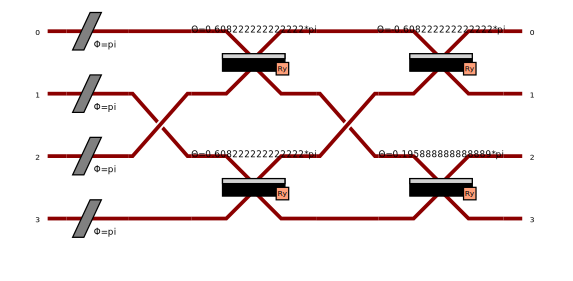

In [5]:
cz = pcvl.Circuit(4, name="Knill CZ")
cz.add((0), new_PS(phi=deg_to_rad(180)))
cz.add((1), new_PS(phi=deg_to_rad(180)))
cz.add((2), new_PS(phi=deg_to_rad(180)))
cz.add((3), new_PS(phi=deg_to_rad(180)))
cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
cz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(54.74), phi=deg_to_rad(0)),
)
cz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(54.74), phi=deg_to_rad(0)),
)
cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
cz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(-54.74), phi=deg_to_rad(0)),
)
cz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(17.63), phi=deg_to_rad(0)),
)

pcvl.pdisplay(cz)

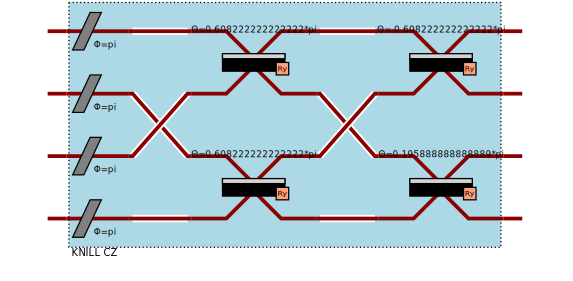

In [6]:
p = pcvl.Processor("SLOS", cz)
p.with_input(pcvl.BasicState("|0,0,1,1>"))
# p.set_postselection(pcvl.PostSelect("[2]==1 & [3]==1"))
pcvl.pdisplay(p, recursive=True)

In [7]:
sampler = Sampler(p)
sampler.probs()["results"]

BSDistribution(float,
               {|2,0,0,0>: 0.19755225896088607,
                |1,1,0,0>: 0.04943623948445133,
                |1,0,1,0>: 0.08088630531311354,
                |1,0,0,1>: 0.14131183475569667,
                |0,2,0,0>: 0.19755225896088607,
                |0,1,1,0>: 0.14131183475569667,
                |0,1,0,1>: 0.08088630531311354,
                |0,0,2,0>: 0.018506482658913782,
                |0,0,1,1>: 0.07404999713832859,
                |0,0,0,2>: 0.018506482658913782})

if the probability of `|*,*,1,1>` is equal to 2/27=0.07407407407407407..., then it is correct

Checking the matrix representation:

In [8]:
cz.U

Matrix([
[                        -1.0*cos(0.304111111111111*pi)**2,                            -0.5*sin(0.391777777777778*pi),                             0.5*sin(0.391777777777778*pi),                          1.0*sin(0.304111111111111*pi)**2],
[                            0.5*sin(0.391777777777778*pi),                         -1.0*cos(0.304111111111111*pi)**2,                         -1.0*sin(0.304111111111111*pi)**2,                             0.5*sin(0.391777777777778*pi)],
[-1.0*sin(0.304111111111111*pi)*cos(0.0979444444444444*pi),  1.0*sin(0.0979444444444444*pi)*sin(0.304111111111111*pi), -1.0*cos(0.0979444444444444*pi)*cos(0.304111111111111*pi),  1.0*sin(0.0979444444444444*pi)*cos(0.304111111111111*pi)],
[-1.0*sin(0.0979444444444444*pi)*sin(0.304111111111111*pi), -1.0*sin(0.304111111111111*pi)*cos(0.0979444444444444*pi), -1.0*sin(0.0979444444444444*pi)*cos(0.304111111111111*pi), -1.0*cos(0.0979444444444444*pi)*cos(0.304111111111111*pi)]])

In [9]:
from sympy import matrix2numpy

cz_U = matrix2numpy(cz.U, dtype=float)
print(cz_U)

[[-0.3332611  -0.47137898  0.47137898  0.6667389 ]
 [ 0.47137898 -0.3332611  -0.6667389   0.47137898]
 [-0.7781897   0.24730485 -0.55017379  0.17484252]
 [-0.24730485 -0.7781897  -0.17484252 -0.55017379]]


In [10]:
ans = np.array(
    [
        [-1 / 3, -np.sqrt(2) / 3, np.sqrt(2) / 3, 2 / 3],
        [np.sqrt(2) / 3, -1 / 3, -2 / 3, np.sqrt(2) / 3],
        [
            -np.sqrt(3 + np.sqrt(6)) / 3,
            np.sqrt(3 - np.sqrt(6)) / 3,
            -np.sqrt((3 + np.sqrt(6)) / 2) / 3,
            np.sqrt(1 / 6 - 1 / (3 * np.sqrt(6))),
        ],
        [
            -np.sqrt(3 - np.sqrt(6)) / 3,
            -np.sqrt(3 + np.sqrt(6)) / 3,
            -np.sqrt(1 / 6 - 1 / (3 * np.sqrt(6))),
            -np.sqrt((3 + np.sqrt(6)) / 2) / 3,
        ],
    ]
)
print(ans)

[[-0.33333333 -0.47140452  0.47140452  0.66666667]
 [ 0.47140452 -0.33333333 -0.66666667  0.47140452]
 [-0.77813807  0.24732126 -0.55022671  0.17488254]
 [-0.24732126 -0.77813807 -0.17488254 -0.55022671]]


In [11]:
np.linalg.norm(cz_U - ans)

0.00019532920397359648

Try parameter optimization:

In [12]:
def optfunc(params):
    cz = pcvl.Circuit(4, name="CZ")
    cz.add((0), new_PS(phi=deg_to_rad(180)))
    cz.add((1), new_PS(phi=deg_to_rad(180)))
    cz.add((2), new_PS(phi=deg_to_rad(180)))
    cz.add((3), new_PS(phi=deg_to_rad(180)))
    cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
    cz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[0]), phi=deg_to_rad(0)),
    )
    cz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[1]), phi=deg_to_rad(0)),
    )
    cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
    cz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[2]), phi=deg_to_rad(0)),
    )
    cz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[3]), phi=deg_to_rad(0)),
    )

    c = (
        pcvl.Circuit(6, name="Heralded CZ")
        .add(1, pcvl.PERM([1, 0]))
        .add(2, cz, merge=True)
        .add(1, pcvl.PERM([1, 0]))
    )

    p = pcvl.Processor("SLOS", 6)
    p.add(2, pcvl.BS.H())
    p.add(0, c)
    p.add(2, pcvl.BS.H())
    p.add_herald(4, 1)
    p.add_herald(5, 1)

    states = {
        pcvl.BasicState([1, 0, 1, 0]): "00",
        pcvl.BasicState([1, 0, 0, 1]): "01",
        pcvl.BasicState([0, 1, 1, 0]): "10",
        pcvl.BasicState([0, 1, 0, 1]): "11",
    }

    ca = pcvl.algorithm.Analyzer(p, states)

    truth_table = {"00": "00", "01": "01", "10": "11", "11": "10"}

    ca.compute(expected=truth_table)

    return 1 - ca.fidelity

In [13]:
init = np.random.rand(4) * 180
res = optimize.minimize(optfunc, init, bounds=[(0, 180)] * 4)
res

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:612: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_lbfgsb_py.py:360: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: (7.530109868980617e-11+0j)
        x: [ 1.002e+02  1.280e+02  1.080e+02  9.593e+01]
      nit: 6
      jac: [-5.551e-08  8.438e-07  3.886e-07  1.776e-07]
     nfev: 35
     njev: 7
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

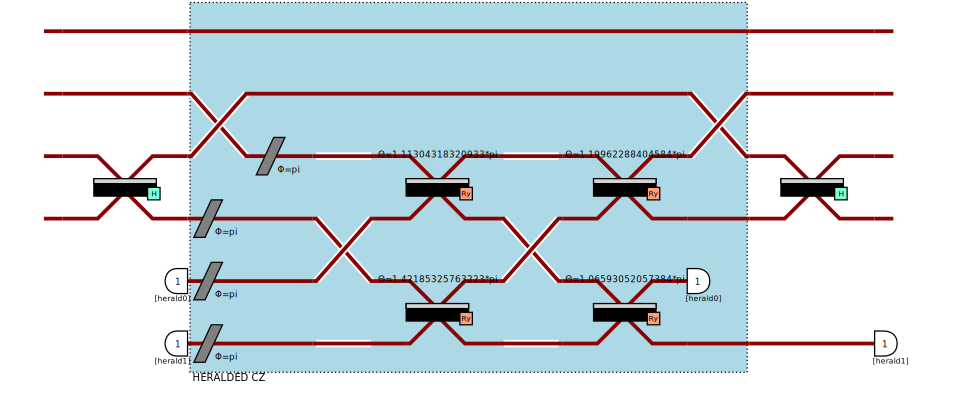

In [14]:
params = res.x

cz = pcvl.Circuit(4, name="Knill CZ")
cz.add((0), new_PS(phi=deg_to_rad(180)))
cz.add((1), new_PS(phi=deg_to_rad(180)))
cz.add((2), new_PS(phi=deg_to_rad(180)))
cz.add((3), new_PS(phi=deg_to_rad(180)))
cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
cz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[0]), phi=deg_to_rad(0)),
)
cz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[1]), phi=deg_to_rad(0)),
)
cz.add((0, 1, 2, 3), pcvl.PERM([0, 2, 1, 3]))
cz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[2]), phi=deg_to_rad(0)),
)
cz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[3]), phi=deg_to_rad(0)),
)

c = (
    pcvl.Circuit(6, name="Heralded CZ")
    .add(1, pcvl.PERM([1, 0]))
    .add(2, cz, merge=True)
    .add(1, pcvl.PERM([1, 0]))
)


p = pcvl.Processor("SLOS", 6)
p.add(2, pcvl.BS.H())
p.add(0, c)
p.add(2, pcvl.BS.H())
p.add_herald(4, 1)
p.add_herald(5, 1)

pcvl.pdisplay(p, recursive=True)

In [15]:
states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11",
}

ca = pcvl.algorithm.Analyzer(p, states)

truth_table = {"00": "00", "01": "01", "10": "11", "11": "10"}

ca.compute(expected=truth_table)
pcvl.pdisplay(ca)
print(f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

,00,01,10,11
00,1,0,0,0
01,0,1,0,0
10,0,0,0,1
11,0,0,1,0


performance = 0.01135611779686673, fidelity = 0.9999999999246989


In [16]:
# reference

processor = pcvl.Processor("SLOS", 4)
processor.add(2, pcvl.BS.H())
processor.add(0, pcvl.catalog["heralded cz"].build_processor())
processor.add(2, pcvl.BS.H())

states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11",
}

ca = pcvl.algorithm.Analyzer(processor, states)

truth_table = {"00": "00", "01": "01", "10": "11", "11": "10"}
ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

,00,01,10,11
00,1,0,0,0
01,0,1,0,0
10,0,0,0,1
11,0,0,1,0


performance = 0.0740660484285117, fidelity = 0.9999999915267557


Reproduce the results from [6]

In [17]:
# define the optimization function


def optfunc(params):
    ccz = pcvl.Circuit(6, name="CCZ")
    ccz.add((0), new_PS(phi=deg_to_rad(180)))
    ccz.add((1), new_PS(phi=deg_to_rad(180)))
    ccz.add((2), new_PS(phi=deg_to_rad(180)))
    ccz.add((3), new_PS(phi=deg_to_rad(180)))
    ccz.add((4), new_PS(phi=deg_to_rad(180)))
    ccz.add((5), new_PS(phi=deg_to_rad(180)))
    ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))
    ccz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[0]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[1]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (4, 5),
        new_BS(theta=deg_to_rad(params[2]), phi=deg_to_rad(0)),
    )
    ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

    ccz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[3]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[4]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (4, 5),
        new_BS(theta=deg_to_rad(params[5]), phi=deg_to_rad(0)),
    )
    ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

    ccz.add(
        (0, 1),
        new_BS(theta=deg_to_rad(params[6]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (2, 3),
        new_BS(theta=deg_to_rad(params[7]), phi=deg_to_rad(0)),
    )
    ccz.add(
        (4, 5),
        new_BS(theta=deg_to_rad(params[8]), phi=deg_to_rad(0)),
    )

    c = (
        pcvl.Circuit(9, name="Heralded CCZ")
        .add(0, pcvl.PERM([0, 3, 1, 4, 2, 5]))
        .add(3, ccz, merge=True)
        .add(0, pcvl.PERM([0, 2, 4, 1, 3, 5]))
    )

    p = pcvl.Processor("SLOS", 9)
    p.add(4, pcvl.BS.H())
    p.add(0, c)
    p.add(4, pcvl.BS.H())
    p.add_herald(6, 1)
    p.add_herald(7, 1)
    p.add_herald(8, 1)

    states = {
        pcvl.BasicState([1, 0, 1, 0, 1, 0]): "000",
        pcvl.BasicState([1, 0, 0, 1, 1, 0]): "010",
        pcvl.BasicState([0, 1, 1, 0, 1, 0]): "100",
        pcvl.BasicState([0, 1, 0, 1, 1, 0]): "110",
        pcvl.BasicState([1, 0, 1, 0, 0, 1]): "001",
        pcvl.BasicState([1, 0, 0, 1, 0, 1]): "011",
        pcvl.BasicState([0, 1, 1, 0, 0, 1]): "101",
        pcvl.BasicState([0, 1, 0, 1, 0, 1]): "111",
    }

    ca = pcvl.algorithm.Analyzer(p, states)

    truth_table = {
        "000": "000",
        "001": "001",
        "010": "010",
        "011": "011",
        "100": "100",
        "101": "101",
        "110": "111",
        "111": "110",
    }
    ca.compute(expected=truth_table)

    return 1 - ca.fidelity  # minimize the infidelity

Do optimization with various methods:

In [18]:
init = np.random.rand(9) * 180
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/perceval/utils/statevector.py:113: UserWarning: Unable to normalize a distribution with only null probabilities
  warnings.warn("Unable to normalize a distribution with only null probabilities")


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [19]:
init = np.random.rand(9) * 180

minimizer_kwargs = {"method": "BFGS", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:303: RuntimeWarning: Method BFGS cannot handle bounds.
  return self.minimizer(self.func, x0, **self.kwargs)
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/_lib/array_api_compat/array_api_compat/common/_aliases.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype=dtype, copy=copy)
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:350: ComplexWarning: Casting complex values to real discards the imaginary part
  w = math.exp(min(0, prod))


                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: (1.8723911310303265e-12+0j)
                          x: [166.47288518+0.j  -7.58768048+0.j
                               38.67995325+0.j  36.82542778+0.j
                              154.55545705+0.j 132.10426225+0.j
                              145.99375252+0.j 157.36533038+0.j
                              157.09670887+0.j]
                        nit: 100
      minimization_failures: 0
                       nfev: 37360
                       njev: 3736
 lowest_optimization_result:  message: Optimization terminated successfully.
                              success: True
                               status: 0
                                  fun: (1.8723911310303265e-12+0j)
                                    x: [166.47288518+0.j  -7.58768048+0.j
                                         38.67995325+0.j  36.82542778

In [20]:
init = np.random.rand(9) * 180

minimizer_kwargs = {"method": "SLSQP", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:431: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: (4.218958260526762e-08+0j)
                          x: [ 1.267e+02  1.694e+02  1.596e+02  1.159e+02
                               1.567e+02  4.680e+01  1.462e+02  3.581e+01
                               7.389e+01]
                        nit: 100
      minimization_failures: 0
                       nfev: 13846
                       njev: 1376
 lowest_optimization_result: message: Optimization terminated successfully
                             success: True
                              status: 0
                                 fun: (4.218958260526762e-08+0j)
                                   x: [ 1.267e+02  1.694e+02  1.596e+02
                                        1.159e+02  1.567e+02  4.680e+01
                                        1.462e+02  3.581e+01  7.389e+01]
                                 nit: 22
      

In [21]:
init = np.random.rand(9) * 180

minimizer_kwargs = {"method": "Nelder-Mead", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_optimize.py:923: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[k] = func(sim[k])
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_optimize.py:959: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxe
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_optimize.py:989: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxcc
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python3.10/site-packages/scipy/optimize/_optimize.py:962: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxr
/home/kazuki_main/.local/share/virtualenvs/2024_Quandela_Remote-q963uaKa/lib/python

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.0
                          x: [ 1.798e+02  5.108e+00  4.451e+01  1.681e+02
                               1.351e+02  1.371e+02  1.333e+02  1.622e+02
                               6.478e+01]
                        nit: 100
      minimization_failures: 0
                       nfev: 40118
 lowest_optimization_result:       message: Optimization terminated successfully.
                                   success: True
                                    status: 0
                                       fun: 0.0
                                         x: [ 1.798e+02  5.108e+00
                                              4.451e+01  1.681e+02
                                              1.351e+02  1.371e+02
                                              1.333e+02  1.622e+02
                                              6.478

In [22]:
init = np.random.rand(9) * 180

minimizer_kwargs = {"method": "Powell", "bounds": [(0, 180)] * 9}
optimize.basinhopping(optfunc, init, minimizer_kwargs=minimizer_kwargs)

TypeError: This operation is not supported for complex128 values because it would be ambiguous.

Testing the optimized parameters:

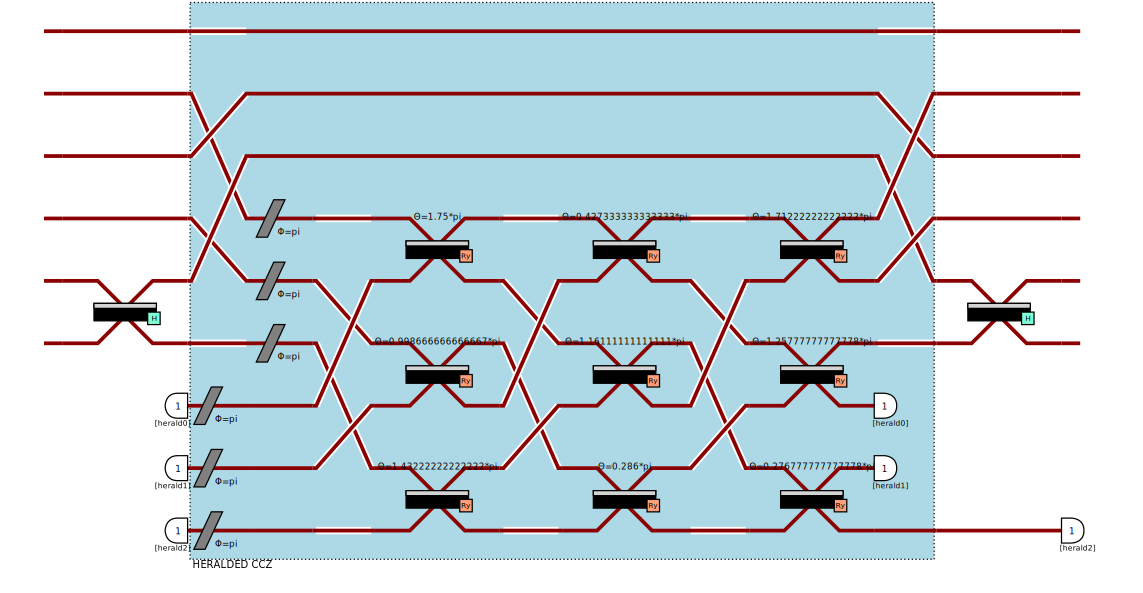

In [ ]:
params = [
    1.575e02,
    8.988e01,
    1.289e02,
    3.846e01,
    1.045e02,
    2.574e01,
    1.541e02,
    1.132e02,
    2.491e01,
]
ccz = pcvl.Circuit(6, name="CCZ")
ccz.add((0), new_PS(phi=deg_to_rad(180)))
ccz.add((1), new_PS(phi=deg_to_rad(180)))
ccz.add((2), new_PS(phi=deg_to_rad(180)))
ccz.add((3), new_PS(phi=deg_to_rad(180)))
ccz.add((4), new_PS(phi=deg_to_rad(180)))
ccz.add((5), new_PS(phi=deg_to_rad(180)))
ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))
ccz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[0]), phi=deg_to_rad(0)),
)
ccz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[1]), phi=deg_to_rad(0)),
)
ccz.add(
    (4, 5),
    new_BS(theta=deg_to_rad(params[2]), phi=deg_to_rad(0)),
)
ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

ccz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[3]), phi=deg_to_rad(0)),
)
ccz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[4]), phi=deg_to_rad(0)),
)
ccz.add(
    (4, 5),
    new_BS(theta=deg_to_rad(params[5]), phi=deg_to_rad(0)),
)
ccz.add((0, 1, 2, 3, 4, 5), pcvl.PERM([0, 2, 4, 1, 3, 5]))

ccz.add(
    (0, 1),
    new_BS(theta=deg_to_rad(params[6]), phi=deg_to_rad(0)),
)
ccz.add(
    (2, 3),
    new_BS(theta=deg_to_rad(params[7]), phi=deg_to_rad(0)),
)
ccz.add(
    (4, 5),
    new_BS(theta=deg_to_rad(params[8]), phi=deg_to_rad(0)),
)

c = (
    pcvl.Circuit(9, name="Heralded CCZ")
    .add(0, pcvl.PERM([0, 3, 1, 4, 2, 5]))
    .add(3, ccz, merge=True)
    .add(0, pcvl.PERM([0, 2, 4, 1, 3, 5]))
)

p = pcvl.Processor("SLOS", 9)
p.add(4, pcvl.BS.H())
p.add(0, c)
p.add(4, pcvl.BS.H())
p.add_herald(6, 1)
p.add_herald(7, 1)
p.add_herald(8, 1)

pcvl.pdisplay(p, recursive=True)

In [ ]:
states = {
    pcvl.BasicState([1, 0, 1, 0, 1, 0]): "000",
    pcvl.BasicState([1, 0, 0, 1, 1, 0]): "010",
    pcvl.BasicState([0, 1, 1, 0, 1, 0]): "100",
    pcvl.BasicState([0, 1, 0, 1, 1, 0]): "110",
    pcvl.BasicState([1, 0, 1, 0, 0, 1]): "001",
    pcvl.BasicState([1, 0, 0, 1, 0, 1]): "011",
    pcvl.BasicState([0, 1, 1, 0, 0, 1]): "101",
    pcvl.BasicState([0, 1, 0, 1, 0, 1]): "111",
}

ca = pcvl.algorithm.Analyzer(p, states)

truth_table = {
    "000": "000",
    "001": "001",
    "010": "010",
    "011": "011",
    "100": "100",
    "101": "101",
    "110": "111",
    "111": "110",
}
ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

,000,010,100,110,001,011,101,111
000,1,0,0,0,0,0,0,0
010,0,0.999967,0,0,0,3.26369e-05,0,0
100,0,0,0.999989,0,0,0,1.13808e-05,0
110,0,0,0,0.00026081,0,0,0,0.999739
001,0,0,0,0,1,0,0,0
011,0,3.26369e-05,0,0,0,0.999967,0,0
101,0,0,1.13808e-05,0,0,0,0.999989,0
111,0,0,0,0.999739,0,0,0,0.00026081


performance = 0.028075761718527957, fidelity = 0.999923727920168


In [24]:
# reference

processor = pcvl.Processor("SLOS", 6)
processor.add(4, pcvl.BS.H())
processor.add(0, pcvl.catalog["postprocessed ccz"].build_processor())
processor.add(4, pcvl.BS.H())

states = {
    pcvl.BasicState([1, 0, 1, 0, 1, 0]): "000",
    pcvl.BasicState([1, 0, 0, 1, 1, 0]): "010",
    pcvl.BasicState([0, 1, 1, 0, 1, 0]): "100",
    pcvl.BasicState([0, 1, 0, 1, 1, 0]): "110",
    pcvl.BasicState([1, 0, 1, 0, 0, 1]): "001",
    pcvl.BasicState([1, 0, 0, 1, 0, 1]): "011",
    pcvl.BasicState([0, 1, 1, 0, 0, 1]): "101",
    pcvl.BasicState([0, 1, 0, 1, 0, 1]): "111",
}

ca = pcvl.algorithm.Analyzer(processor, states)

truth_table = {
    "000": "000",
    "001": "001",
    "010": "010",
    "011": "011",
    "100": "100",
    "101": "101",
    "110": "111",
    "111": "110",
}
ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

,000,010,100,110,001,011,101,111
000,1,0,0,0,0,0,0,0
010,0,1,0,0,0,0,0,0
100,0,0,1,0,0,0,0,0
110,0,0,0,0,0,0,0,1
001,0,0,0,0,1,0,0,0
011,0,0,0,0,0,1,0,0
101,0,0,0,0,0,0,1,0
111,0,0,0,1,0,0,0,0


performance = 0.017559993780020683, fidelity = 1.0
